# Pseudo Virtual Fields: Neural Networks act as Taylor expansions to find optimal virtual fields via weak equilibrium minimization

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from helper_FEBIO import *
from VF_helper import *
from model import *
from plot_helper import *

In [4]:
import sys
sys.path.insert(0, '../')
from core import *
#config
from config import *
#CUDA
cuda=0
device=initCUDA(cuda)
#supporting files


-----------------------------------------------------
Setting device to:  0
Test:  cuda:0
-----------------------------------------------------



/home/feolalab/anaconda3/envs/NNEUCLID/lib/python3.9/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


# Read FEBIO data

In [5]:
#Read connectivity
connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/connectivity")
connectivity

,1,1,9,133,52,24,57,153,108
0,2,9,10,134,133,57,58,154,153
1,3,10,11,135,134,58,59,155,154
2,4,11,12,136,135,59,60,156,155
3,5,12,2,25,136,60,13,73,156
4,6,52,133,129,51,108,153,157,107
...,...,...,...,...,...,...,...,...,...
119,121,117,213,104,44,56,149,45,8
120,122,213,214,103,104,149,150,46,45
121,123,214,215,102,103,150,151,47,46
122,124,215,216,101,102,151,152,48,47


In [6]:
#Read connectivity
facet_connectivity = pd.read_csv("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/facet_area_connectivity")
facet_connectivity

,1,1,9,57,24
0,2,52,1,24,108
1,3,52,133,9,1
2,4,9,10,58,57
3,5,133,134,10,9
4,6,10,11,59,58
...,...,...,...,...,...
144,146,101,102,47,48
145,147,151,152,48,47
146,148,88,32,7,33
147,149,32,101,48,7


### Function to read multiple states from FEBIO file

In [7]:
volume_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/volume"
volume=read_multi_ste_output2(volume_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=125
 State 2: element=125
 State 3: element=125
 State 4: element=125
 State 5: element=125
 State 6: element=125
 State 7: element=125
 State 8: element=125
 State 9: element=125
 State 10: element=125
 State 11: element=125


In [8]:
area_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/facet_area"
area=read_multi_ste_output2(area_file,p=True) 

Detected 1-field blocks → ['element']
Number of states: 11
 State 1: element=150
 State 2: element=150
 State 3: element=150
 State 4: element=150
 State 5: element=150
 State 6: element=150
 State 7: element=150
 State 8: element=150
 State 9: element=150
 State 10: element=150
 State 11: element=150


In [9]:
stress_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/stress"
stress=read_multi_ste_output2(stress_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 2: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 3: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 4: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 5: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 6: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 7: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 8: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 9: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 10: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 11: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125


In [10]:
F_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/deformation.txt"
F=read_multi_stepped_output_txt(F_file,p=True)

Step 0: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 1: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 2: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 3: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 4: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 5: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 6: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 7: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 8: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 9: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125
Step 10: Fxx=125, Fxy=125, Fxz=125, Fyx=125, Fyy=125, Fyz=125, Fzx=125, Fzy=125, Fzz=125


In [11]:
surface_normal_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/surface_normal"
surface_normal=read_multi_ste_output2(surface_normal_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=150, y=150, z=150
 State 2: x=150, y=150, z=150
 State 3: x=150, y=150, z=150
 State 4: x=150, y=150, z=150
 State 5: x=150, y=150, z=150
 State 6: x=150, y=150, z=150
 State 7: x=150, y=150, z=150
 State 8: x=150, y=150, z=150
 State 9: x=150, y=150, z=150
 State 10: x=150, y=150, z=150
 State 11: x=150, y=150, z=150


In [12]:
position_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/position"
position=read_multi_ste_output2(position_file,p=True)

Detected 3-field blocks → ['x', 'y', 'z']
Number of states: 11
 State 1: x=216, y=216, z=216
 State 2: x=216, y=216, z=216
 State 3: x=216, y=216, z=216
 State 4: x=216, y=216, z=216
 State 5: x=216, y=216, z=216
 State 6: x=216, y=216, z=216
 State 7: x=216, y=216, z=216
 State 8: x=216, y=216, z=216
 State 9: x=216, y=216, z=216
 State 10: x=216, y=216, z=216
 State 11: x=216, y=216, z=216


In [13]:
strain_file="/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/output_files/lagrange_strain"
strain=read_multi_ste_output2(strain_file,p=True)

Detected 6-field blocks → ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
Number of states: 11
 State 1: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 2: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 3: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 4: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 5: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 6: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 7: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 8: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 9: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 10: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125
 State 11: xx=125, yy=125, zz=125, xy=125, xz=125, yz=125


### Log file data

In [14]:
#Centroids from log file
centroids_file='/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Cube_v1.log'
centroids_dict  = parse_states(centroids_file)

#Should get 11 states, each with exactly 1000 x/y/z values:
print("states found:", sorted(centroids_dict.keys()))
for step, d in centroids_dict.items():
    print(f" step {step:2d}: x={len(d['x'])} pts, y={len(d['y'])}, z={len(d['z'])}")

states found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 step  0: x=125 pts, y=125, z=125
 step  1: x=125 pts, y=125, z=125
 step  2: x=125 pts, y=125, z=125
 step  3: x=125 pts, y=125, z=125
 step  4: x=125 pts, y=125, z=125
 step  5: x=125 pts, y=125, z=125
 step  6: x=125 pts, y=125, z=125
 step  7: x=125 pts, y=125, z=125
 step  8: x=125 pts, y=125, z=125
 step  9: x=125 pts, y=125, z=125
 step 10: x=125 pts, y=125, z=125


### State dict to tensor

In [15]:
# 1) Build a (Nelements,3,nstates) tensor for centroids:
centroids_tensor = states_to_tensor(centroids_dict, ['x','y','z'])
print("centroids_tensor.shape:", centroids_tensor.shape)
# → (Nelements, 3, nstates)

# 2) Build a (Nelements,6,nstates) tensor for volume‐stress:
stress_tensor = states_to_tensor(stress,
                                ['xx','yy','zz','xy','xz','yz'])
print("stress_tensor.shape:", stress_tensor.shape)
# → (Nelements, 6, nstates)

# 3) If you just want the x‐only channel across states:
#x_only = states_to_tensor(centroids_dict, ['x'])
#print("x_only.shape:", x_only.shape)
# → (Nelements, 1, nstates)

# 3) Volume:
volume_tensor = states_to_tensor(volume, ['element'])
print("volume_tensor.shape:", volume_tensor.shape)
# → (Nelements, 1, nstates)

# 4) Deformation tensor:
F_tensor = states_to_tensor(F, ['Fxx','Fxy','Fxz','Fyx','Fyy','Fyz','Fzx','Fzy','Fzz'])
print("F_tensor.shape:", F_tensor.shape)

# 4) Surface Normal:
surface_normal_tensor = states_to_tensor(surface_normal, ['x','y','z'])
print("surface_normal_tensor.shape:", surface_normal_tensor.shape)


# 5) Area:
area_tensor = states_to_tensor(area, ['element'])
print("area_tensor.shape:", area_tensor.shape)


# 6) Strain:
#del strain[1]
strain_tensor = states_to_tensor(strain, ['xx','yy','zz','xy','xz','yz'])
print("strain_tensor.shape:", strain_tensor.shape)

position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

centroids_tensor.shape: torch.Size([125, 3, 11])
stress_tensor.shape: torch.Size([125, 6, 11])
volume_tensor.shape: torch.Size([125, 1, 11])
F_tensor.shape: torch.Size([125, 9, 11])
surface_normal_tensor.shape: torch.Size([150, 3, 11])
area_tensor.shape: torch.Size([150, 1, 11])
strain_tensor.shape: torch.Size([125, 6, 11])
strain_tensor.shape: torch.Size([216, 3, 11])


In [16]:
position_tensor = states_to_tensor(position, ['x','y','z'])
print("strain_tensor.shape:", position_tensor.shape)

strain_tensor.shape: torch.Size([216, 3, 11])


In [17]:
torch.sum(centroids_tensor[:,:,0], dim=(0,1))

tensor(62.5000, dtype=torch.float32)

In [18]:
Nelements=F_tensor.shape[0]
Nelements

125

## Where pressure is applied and Zero Displacement Boundary Conditions

In [19]:
pressure_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Cube_v1.feb", surface_name="Pressure1")
pressure_node_ids = list(pressure_nodes.keys())

In [20]:
pressure_nodes[1], type(pressure_nodes)

([5, 20, 137, 53], dict)

In [21]:
ZD_nodes = parse_quad4_from_feb("/home/feolalab/Desktop/EUCLID-hyperelasticity-NN/my_data/Cube/jobs/Cube_v1.feb", surface_name="ZeroDisplacement1")
ZD_node_ids = list(ZD_nodes.keys())
ZD_idx = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)
ZD_idx[:10], ZD_node_ids[:10]

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [22]:
ZD_nodes[1], len(ZD_node_ids)

([4, 40, 121, 49], 25)

In [23]:
connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in connectivity.values
]

In [24]:
# 2) Flatten pressure-node dict into a set of node IDs
pressure_nodes_set = {
    n
    for nodes in pressure_nodes.values()
    for n in nodes
}

mapping_element_pressure = map_pressure_to_elements(connectivity_list, pressure_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 101:
  all_nodes:      [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes: [5, 20, 137, 53]
Element 102:
  all_nodes:      [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes: [20, 19, 138, 137]
Element 103:
  all_nodes:      [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes: [19, 18, 139, 138]
Element 104:
  all_nodes:      [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes: [18, 17, 140, 139]
Element 105:
  all_nodes:      [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes: [17, 6, 36, 140]
Element 106:
  all_nodes:      [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes: [53, 137, 141, 54]
Element 107:
  all_nodes:      [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes: [137, 138, 142, 141]
Element 108:
  all_nodes:      [202, 203, 207, 206, 138, 139, 143, 142]
  pressure_nodes: [138, 139, 143, 142]
Element 109:
  all_nodes:      [203, 204, 208, 207, 139, 140, 144, 143]
  pressure_nodes: [139, 140, 144, 143]
Element 110:
  all_nodes:      [204, 85, 86,

In [25]:
# 2) Flatten pressure-node dict into a set of node IDs
ZD_nodes_set = {
    n
    for nodes in ZD_nodes.values()
    for n in nodes
}

mapping_element_ZD = map_pressure_to_elements(connectivity_list, ZD_nodes_set)
#print(mapping.keys())
# (3) inspect
for eid, info in mapping_element_ZD.items():
    print(f"Element {eid}:")
    print("  all_nodes:     ", info['all_nodes'])
    print("  pressure_nodes:", info['pressure_nodes'])

Element 2:
  all_nodes:      [9, 10, 134, 133, 57, 58, 154, 153]
  pressure_nodes: [9, 10, 134, 133]
Element 3:
  all_nodes:      [10, 11, 135, 134, 58, 59, 155, 154]
  pressure_nodes: [10, 11, 135, 134]
Element 4:
  all_nodes:      [11, 12, 136, 135, 59, 60, 156, 155]
  pressure_nodes: [11, 12, 136, 135]
Element 5:
  all_nodes:      [12, 2, 25, 136, 60, 13, 73, 156]
  pressure_nodes: [12, 2, 25, 136]
Element 6:
  all_nodes:      [52, 133, 129, 51, 108, 153, 157, 107]
  pressure_nodes: [52, 133, 129, 51]
Element 7:
  all_nodes:      [133, 134, 130, 129, 153, 154, 158, 157]
  pressure_nodes: [133, 134, 130, 129]
Element 8:
  all_nodes:      [134, 135, 131, 130, 154, 155, 159, 158]
  pressure_nodes: [134, 135, 131, 130]
Element 9:
  all_nodes:      [135, 136, 132, 131, 155, 156, 160, 159]
  pressure_nodes: [135, 136, 132, 131]
Element 10:
  all_nodes:      [136, 25, 26, 132, 156, 73, 74, 160]
  pressure_nodes: [136, 25, 26, 132]
Element 11:
  all_nodes:      [51, 129, 125, 50, 107, 157, 

In [26]:
pressure_element_IDs=list(mapping_element_pressure.keys())

pressure_element_IDs_final = torch.tensor([nid - 1 for nid in pressure_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [27]:
ZD_element_IDs=list(mapping_element_ZD.keys())

ZD_element_IDs_final = torch.tensor([nid - 1 for nid in ZD_element_IDs], dtype=torch.long)

#len(pressure_element_IDs_final)

In [28]:
#Get normals of surfaces where pressure is applied
# 1) zero‐based indices for those nodes:
idx = torch.tensor([nid - 1 for nid in pressure_node_ids], dtype=torch.long)
idx_ZD = torch.tensor([nid - 1 for nid in ZD_node_ids], dtype=torch.long)

# 2) index into the first dimension:
#    result has shape (100, 3, 11)
pressure_normals = surface_normal_tensor[idx, :, :]
area_normals = area_tensor[idx, :, :]

#ZD:
ZD_normals = surface_normal_tensor[idx_ZD, :, :]
ZD_areas = area_tensor[idx_ZD, :, :]


print(pressure_normals.shape)  # → torch.Size([100, 3, 11])
print(ZD_normals.shape)  # → torch.Size([100, 3, 11])

torch.Size([25, 3, 11])
torch.Size([25, 3, 11])


In [29]:
#print("VF.shape =", VF.shape)
print("max idx =", max(pressure_element_IDs_final).item())
print("min idx =", min(pressure_element_IDs_final).item())


max idx = 124
min idx = 100


# Surface Normals

In [30]:
surface_normal_tensor.shape

torch.Size([150, 3, 11])

In [31]:
facet_connectivity_list = [
    tuple(map(int, row))           # ensure ints
    for row in facet_connectivity.values
]

In [32]:
facet_connectivity_list

[(2, 52, 1, 24, 108),
 (3, 52, 133, 9, 1),
 (4, 9, 10, 58, 57),
 (5, 133, 134, 10, 9),
 (6, 10, 11, 59, 58),
 (7, 134, 135, 11, 10),
 (8, 11, 12, 60, 59),
 (9, 135, 136, 12, 11),
 (10, 12, 2, 13, 60),
 (11, 2, 25, 73, 13),
 (12, 136, 25, 2, 12),
 (13, 51, 52, 108, 107),
 (14, 51, 129, 133, 52),
 (15, 129, 130, 134, 133),
 (16, 130, 131, 135, 134),
 (17, 131, 132, 136, 135),
 (18, 25, 26, 74, 73),
 (19, 132, 26, 25, 136),
 (20, 50, 51, 107, 106),
 (21, 50, 125, 129, 51),
 (22, 125, 126, 130, 129),
 (23, 126, 127, 131, 130),
 (24, 127, 128, 132, 131),
 (25, 26, 27, 75, 74),
 (26, 128, 27, 26, 132),
 (27, 49, 50, 106, 105),
 (28, 49, 121, 125, 50),
 (29, 121, 122, 126, 125),
 (30, 122, 123, 127, 126),
 (31, 123, 124, 128, 127),
 (32, 27, 28, 76, 75),
 (33, 124, 28, 27, 128),
 (34, 40, 4, 41, 92),
 (35, 4, 49, 105, 41),
 (36, 4, 40, 121, 49),
 (37, 39, 40, 92, 91),
 (38, 40, 39, 122, 121),
 (39, 38, 39, 91, 90),
 (40, 39, 38, 123, 122),
 (41, 37, 38, 90, 89),
 (42, 38, 37, 124, 123),
 (43,

In [33]:
facet2elems = map_facets_to_elements(connectivity_list, facet_connectivity_list)
for fid, info in facet2elems.items():
    print(f"Facet {fid} with nodes {info['facet_nodes']} → elements {info['element_ids']}")

Facet 4 with nodes [9, 10, 58, 57] → elements [2]
Facet 5 with nodes [133, 134, 10, 9] → elements [2]
Facet 6 with nodes [10, 11, 59, 58] → elements [3]
Facet 7 with nodes [134, 135, 11, 10] → elements [3]
Facet 8 with nodes [11, 12, 60, 59] → elements [4]
Facet 9 with nodes [135, 136, 12, 11] → elements [4]
Facet 10 with nodes [12, 2, 13, 60] → elements [5]
Facet 11 with nodes [2, 25, 73, 13] → elements [5]
Facet 12 with nodes [136, 25, 2, 12] → elements [5]
Facet 13 with nodes [51, 52, 108, 107] → elements [6]
Facet 14 with nodes [51, 129, 133, 52] → elements [6]
Facet 15 with nodes [129, 130, 134, 133] → elements [7]
Facet 16 with nodes [130, 131, 135, 134] → elements [8]
Facet 17 with nodes [131, 132, 136, 135] → elements [9]
Facet 18 with nodes [25, 26, 74, 73] → elements [10]
Facet 19 with nodes [132, 26, 25, 136] → elements [10]
Facet 20 with nodes [50, 51, 107, 106] → elements [11]
Facet 21 with nodes [50, 125, 129, 51] → elements [11]
Facet 22 with nodes [125, 126, 130, 129] →

In [34]:
element2facets = {}
for facet_id, info in facet2elems.items():
    for eid in info['element_ids']:
        element2facets.setdefault(eid, []).append(facet_id) 
element2facets

{2: [4, 5],
 3: [6, 7],
 4: [8, 9],
 5: [10, 11, 12],
 6: [13, 14],
 7: [15],
 8: [16],
 9: [17],
 10: [18, 19],
 11: [20, 21],
 12: [22],
 13: [23],
 14: [24],
 15: [25, 26],
 16: [27, 28],
 17: [29],
 18: [30],
 19: [31],
 20: [32, 33],
 21: [34, 35, 36],
 22: [37, 38],
 23: [39, 40],
 24: [41, 42],
 25: [43, 44, 45],
 26: [46, 47],
 27: [48],
 28: [49],
 29: [50],
 30: [51, 52],
 31: [53],
 35: [54],
 36: [55],
 40: [56],
 41: [57],
 45: [58],
 46: [59, 60],
 47: [61],
 48: [62],
 49: [63],
 50: [64, 65],
 51: [66, 67],
 52: [68],
 53: [69],
 54: [70],
 55: [71, 72],
 56: [73],
 60: [74],
 61: [75],
 65: [76],
 66: [77],
 70: [78],
 71: [79, 80],
 72: [81],
 73: [82],
 74: [83],
 75: [84, 85],
 76: [86, 87],
 77: [88],
 78: [89],
 79: [90],
 80: [91, 92],
 81: [93],
 85: [94],
 86: [95],
 90: [96],
 91: [97],
 95: [98],
 96: [99, 100],
 97: [101],
 98: [102],
 99: [103],
 100: [104, 105],
 101: [106, 107, 108],
 102: [109, 110],
 103: [111, 112],
 104: [113, 114],
 105: [115, 116, 1

In [35]:
eid, idx

(125,
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24]))

In [36]:
# 1) select only the pressured elements
pressure_elements_facets = {
    eid-1: element2facets[eid] #minus one to account for python indexing
    for eid in pressure_element_IDs
    if eid in element2facets
}

In [37]:
for eid, info in mapping_element_pressure.items():
    pset = set(info['pressure_nodes'])
    # find the facet(s) whose node-set exactly matches the pressure nodes
    facet_ids = [
        fid
        for fid, n1, n2, n3, n4 in facet_connectivity_list
        if set((n1, n2, n3, n4)) == pset
    ]
    info['facet_ids'] = facet_ids

# inspect
for eid, info in mapping_element_pressure.items():
    print(f"Element {eid}:")
    print("  all_nodes:      ", info['all_nodes'])
    print("  pressure_nodes: ", info['pressure_nodes'])
    print("  facet_ids:      ", info.get('facet_ids', []))

Element 101:
  all_nodes:       [21, 69, 201, 120, 5, 20, 137, 53]
  pressure_nodes:  [5, 20, 137, 53]
  facet_ids:       [108]
Element 102:
  all_nodes:       [69, 70, 202, 201, 20, 19, 138, 137]
  pressure_nodes:  [20, 19, 138, 137]
  facet_ids:       [110]
Element 103:
  all_nodes:       [70, 71, 203, 202, 19, 18, 139, 138]
  pressure_nodes:  [19, 18, 139, 138]
  facet_ids:       [112]
Element 104:
  all_nodes:       [71, 72, 204, 203, 18, 17, 140, 139]
  pressure_nodes:  [18, 17, 140, 139]
  facet_ids:       [114]
Element 105:
  all_nodes:       [72, 16, 85, 204, 17, 6, 36, 140]
  pressure_nodes:  [17, 6, 36, 140]
  facet_ids:       [117]
Element 106:
  all_nodes:       [120, 201, 205, 119, 53, 137, 141, 54]
  pressure_nodes:  [53, 137, 141, 54]
  facet_ids:       [119]
Element 107:
  all_nodes:       [201, 202, 206, 205, 137, 138, 142, 141]
  pressure_nodes:  [137, 138, 142, 141]
  facet_ids:       [120]
Element 108:
  all_nodes:       [202, 203, 207, 206, 138, 139, 143, 142]
  pr

In [38]:
pressure_elem_facets_indexes = [
    (eid-1, fid-1)
    for eid, info in mapping_element_pressure.items()
    for fid in info.get('facet_ids', [])
]
pressure_elem_facets_indexes[0]

(100, 107)

In [39]:
# 1) Extract index lists
elem_idxs  = torch.tensor([e for e, f in pressure_elem_facets_indexes], dtype=torch.long)
facet_idxs = torch.tensor([f for e, f in pressure_elem_facets_indexes], dtype=torch.long)

# Architecture

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
del model

NameError: name 'model' is not defined

In [106]:
from model import *

vf_number=2 #linear elastic is 2 parameters
model = ICNN3D_Taylor_multifield_with_neg(n_input=3,
                n_hidden=[64,64,64],
                n_output=30,
                use_dropout=True,
                dropout_rate=0.2,
                centroids=True, p_fields=vf_number)

In [107]:
from torchinfo import summary
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ICNN3D_Taylor_multifield_with_neg        --
├─ModuleDict: 1-1                        --
│    └─Linear: 2-1                       448
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       3,900
├─ModuleDict: 1-2                        --
│    └─Linear: 2-5                       448
│    └─Linear: 2-6                       448
│    └─Linear: 2-7                       420
├─AdaptiveAvgPool1d: 1-3                 --
Total params: 13,984
Trainable params: 13,984
Non-trainable params: 0

## Training loop

In [44]:
F_tensor.shape, stress_tensor.shape, centroids_tensor.shape

(torch.Size([125, 9, 11]), torch.Size([125, 6, 11]), torch.Size([125, 3, 11]))

In [45]:
x_input= torch.cat(( F_tensor.to(device),centroids_tensor.to(device)), dim=1)
#x_input= F_tensor.to(device)
x_input.shape

torch.Size([125, 12, 11])

In [46]:
stress_tensor_3d=Voigt_to_3d(stress_tensor)

In [47]:
model.apply(init_weights)

ICNN3D_Taylor_multifield_with_neg(
  (layers): ModuleDict(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=60, bias=True)
  )
  (skip_layers): ModuleDict(
    (1): Linear(in_features=6, out_features=64, bias=True)
    (2): Linear(in_features=6, out_features=64, bias=True)
    (3): Linear(in_features=6, out_features=60, bias=True)
  )
  (global_pooling): AdaptiveAvgPool1d(output_size=1)
)

In [48]:

def evaluate_vf_values(V_NN: torch.Tensor, delta_xyz: torch.Tensor):
    """
    Evaluate p global Taylor‐expanded virtual fields at N points.

    Args:
        V_NN       (torch.Tensor): shape [p, 30], Taylor coefficients for p fields
        delta_xyz  (torch.Tensor): shape [N,  3], the (x,y,z) offsets

    Returns:
        torch.Tensor: shape [p, N, 3], where each slice [k] is the (Vx,Vy,Vz)
                      values of the k+th virtual field at all N points.
    """
    # Split out the 10‐wide blocks for Vx, Vy, Vz respectively
    Vx_coeff = V_NN[:,  0:10]   # [p,10]
    Vy_coeff = V_NN[:, 10:20]
    Vz_coeff = V_NN[:, 20:30]

    # Build the N×10 design matrix of monomials
    x, y, z = delta_xyz[:,0], delta_xyz[:,1], delta_xyz[:,2]
    B = torch.stack([
        torch.ones_like(x),
        x, y, z,
        x**2, y**2, z**2,
        x*y, x*z, y*z
    ], dim=1)  # [N,10]

    # Multiply coefficients by monomials: (p×10) @ (10×N) → (p×N)
    Vx_vals = Vx_coeff @ B.T
    Vy_vals = Vy_coeff @ B.T
    Vz_vals = Vz_coeff @ B.T

    # Stack into (p, N, 3)
    return torch.stack([Vx_vals, Vy_vals, Vz_vals], dim=2)


In [49]:
import torch

def construct_VF_gradients_batch(V_NN: torch.Tensor, delta_xyz: torch.Tensor) -> torch.Tensor:
    """
    Vectorized gradient of p global Taylor‐expanded VFs at N points.

    Args:
        V_NN       (torch.Tensor): shape [p, 30], Taylor coefficients for p VFs
        delta_xyz  (torch.Tensor): shape [N,  3], the (x,y,z) offsets

    Returns:
        torch.Tensor: shape [p, N, 3, 3], where
                      out[k,i] is the 3×3 gradient tensor of the k-th VF at point i.
    """
    p, coeff_len = V_NN.shape
    N, _         = delta_xyz.shape
    if coeff_len != 30:
        raise ValueError(f"Expected V_NN with 30 coefficients, got {coeff_len}")

    # Prepare delta for broadcasting: [1, N]
    dx = delta_xyz[:, 0].unsqueeze(0)
    dy = delta_xyz[:, 1].unsqueeze(0)
    dz = delta_xyz[:, 2].unsqueeze(0)

    # Split into Vx, Vy, Vz coefficient blocks [p,10]
    a = V_NN[:,  0:10]
    b = V_NN[:, 10:20]
    c = V_NN[:, 20:30]

    # Helper to extract and unsqueeze a given index
    def e(block, idx):
        return block[:, idx].unsqueeze(1)  # [p,1]

    # Extract and unsqueeze needed coeffs
    a1,a2,a3 = e(a,1), e(a,2), e(a,3)
    a4,a5,a6 = e(a,4), e(a,5), e(a,6)
    a7,a8,a9 = e(a,7), e(a,8), e(a,9)
    b1,b2,b3 = e(b,1), e(b,2), e(b,3)
    b4,b5,b6 = e(b,4), e(b,5), e(b,6)
    b7,b8,b9 = e(b,7), e(b,8), e(b,9)
    c1,c2,c3 = e(c,1), e(c,2), e(c,3)
    c4,c5,c6 = e(c,4), e(c,5), e(c,6)
    c7,c8,c9 = e(c,7), e(c,8), e(c,9)

    # Compute partials [p,N]
    dVx_dx = +a1 + 2*a4*dx +    a7*dy +    a8*dz
    dVx_dy = +a2 +    a7*dx + 2*a5*dy +    a9*dz
    dVx_dz = +a3 +    a8*dx +    a9*dy + 2*a6*dz

    dVy_dx = +b1 + 2*b4*dx +    b7*dy +    b8*dz
    dVy_dy = +b2 +    b7*dx + 2*b5*dy +    b9*dz
    dVy_dz = +b3 +    b8*dx +    b9*dy + 2*b6*dz

    dVz_dx = +c1 + 2*c4*dx +    c7*dy +    c8*dz
    dVz_dy = +c2 +    c7*dx + 2*c5*dy +    c9*dz
    dVz_dz = +c3 +    c8*dx +    c9*dy + 2*c6*dz

    # Stack into [p,N,3,3]
    grad = torch.stack([
        torch.stack([dVx_dx, dVx_dy, dVx_dz], dim=2),
        torch.stack([dVy_dx, dVy_dy, dVy_dz], dim=2),
        torch.stack([dVz_dx, dVz_dy, dVz_dz], dim=2)
    ], dim=2)

    return grad


#### Train
If we keep the strain pointwise throughout the solid we can get a map of parameters...

In [51]:
epoch=150
# Adam with a learning rate:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#Number of states:
states=x_input.shape[2]
N_pressure_dofs=len(pressure_element_IDs_final)
N_ZD_dofs=len(ZD_element_IDs_final)
loss_list=[]
keys = ['Internal', 'External', 'ZD','Special']
work_dict = { key: [] for key in keys }
for i in range(epoch):
    optimizer.zero_grad()#reset gradients
    loss = torch.zeros((), device=device)    # scalar, same dtype/device
    #Estimate
    for s in range(1,states):
        V_NN=model(x_input[:,:,s]) #This is VF,30

        delta_xyz=calculate_point(centroids_tensor, s) #This is N elements x3

        VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 
        
        grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz) #This is p,N,3,3 . 

        #Strain
        virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3))

        #Volume integral:
        
        # element‐wise inner product σ^e : ∇v^e
        integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(0) * virtual_strain, dim=(2, 3)) # → shape [p,N]
       # print(f'Integrand shape: {integrand.shape}')
        W_int = torch.sum(integrand * volume_tensor[:,0,s].unsqueeze(0) ,dim=(0,1))/(Nelements*vf_number)

       # print(f'W_int shape: {W_int.shape}')
        #Surface integral
        #Adding negative to the pressure becuase it is applied downwards...
        t_surface=surface_normal_tensor[facet_idxs,:,s]*(-100000)*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
     #   print(f'W_int shape: {W_int.shape}')
        dot = (VF_values[:,elem_idxs,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

        W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(0,1))/(N_pressure_dofs*vf_number)

        ## Add ZD term:
        #ZD_regularization=torch.sum(VF_values[:,ZD_element_IDs_final,:]**2, dim=(0,1,2))/(N_ZD_dofs*vf_number)
        VF_values_NODES = evaluate_vf_values(V_NN, position_tensor[ZD_idx,:,s]) #This is p, N, 3 
        ZD_regularization=torch.sum(VF_values_NODES[:,ZD_idx,:]**2, dim=(0,1,2))/(len(ZD_idx)*vf_number)
        
        ## SPECIAL VIRTUAL FIELDS
        # 1) Extract normal & shear strains from strain_tensor (Voigt):
        ε_xx = strain_tensor[:, 0, s] #.detach().cpu().numpy()   # (1000,)
        ε_yy = strain_tensor[:, 1,s]#.detach().cpu().numpy()
        ε_zz = strain_tensor[:, 2,s]#.detach().cpu().numpy()
        ε_xy = strain_tensor[:, 3,s]#.detach().cpu().numpy()
        ε_yz = strain_tensor[:, 4,s]#.detach().cpu().numpy()
        ε_zx = strain_tensor[:, 5,s]#.detach().cpu().numpy()

        # 2) Extract corresponding dotted strains from virtual_strain:
        εd_xx = virtual_strain[:,:, 0, 0]
        εd_yy = virtual_strain[:,:, 1, 1]
        εd_zz = virtual_strain[:,:, 2, 2]
        εd_xy = virtual_strain[:,:, 0, 1]  # = virtual_strain[:,1,0]
        εd_yz = virtual_strain[:,:, 1, 2]  # = virtual_strain[:,2,1]
        εd_zx = virtual_strain[:,:, 2, 0]  # = virtual_strain[:,0,2]


        #Now the A matrix:
        A1= (ε_xx+ε_yy+ε_zz)*(εd_xx+εd_yy+εd_zz)* volume_tensor[:,0,s]
        A2= (ε_xx * εd_xx + ε_yy * εd_yy +ε_zz * εd_zz +2 * (ε_xy * εd_xy +ε_yz * εd_yz +ε_zx * εd_zx))* volume_tensor[:,0,s]

       # print(A1.sum().item())
        #print(A2.sum().item())
#
        A = torch.stack([A1, A2], dim=1)  # -> (1000,6)
        M = A.mean(dim=2)                   # shape (2, 2):  M[k] = [ I_v^(k), I_d^(k) ]

      #  print(A.sum().item())
        # 1) make a [6,6,1] identity tensor

        I = torch.eye(2, device=A.device) #.unsqueeze(2)   # now I.shape == (6,6,1)

        # 2) subtract it from each slice of A
        A_minus_I = A.mean(dim=2) - I   # broadcasts I to (6,6,1000)
        #print(A_minus_I.sum().item())
        
        special_loss = torch.sum(A_minus_I**2)

        #Loss:
        loss+=(W_int-W_ext)**2+ZD_regularization+special_loss*0.1

    loss/=states
    loss_list.append(loss.item())
    work_dict['Internal'].append(W_int.item())
    work_dict['External'].append(W_ext.item())
    work_dict['ZD'].append(ZD_regularization.item())

    if i % 50 == 0:
        W_int_item = W_int.item()
        W_ext_item = W_ext.item()
        ZD_regularization_item= ZD_regularization.item()
        special_loss_item= special_loss.item()*0.1
        L_item    = loss.item()
        print(
            f"Epoch {i:4d} │ "
            f"W_int (internal work): {W_int_item: .2e} │ "
            f"W_ext (external work): {W_ext_item: .2e} │ "
            f"Zero Displacement term: {ZD_regularization_item: .2e} │ "
            f"Special Loss term: {special_loss_item: .4e} │ "
            f"Loss: {L_item: .2e}"
        )

    loss.backward()

    optimizer.step()

Epoch    0 │ W_int (internal work): -1.37e+00 │ W_ext (external work): -1.68e+00 │ Zero Displacement term:  3.69e-02 │ Special Loss term:  5.2687e-01 │ Loss:  4.34e-01
Epoch   50 │ W_int (internal work): -5.07e+00 │ W_ext (external work): -1.29e+00 │ Zero Displacement term:  4.30e-02 │ Special Loss term:  4.5475e+00 │ Loss:  7.91e+00
Epoch  100 │ W_int (internal work): -1.20e+00 │ W_ext (external work): -1.84e+00 │ Zero Displacement term:  4.25e-02 │ Special Loss term:  7.2216e-01 │ Loss:  4.82e-01


In [109]:
A.shape, A1.shape, A2.shape

(torch.Size([2, 2, 125]), torch.Size([2, 125]), torch.Size([2, 125]))

In [52]:
strain_tensor.shape

torch.Size([125, 6, 11])

In [53]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = -0.009*1 + +0.038*x + -0.058*y + +0.035*z + -0.001*x**2 + -0.033*x*y + +0.006*x*z + +0.012*y**2 + -0.056*y*z + +0.118*z**2
Vy(x,y,z) = -0.161*1 + -0.120*x + -0.392*y + -0.579*z + +0.594*x**2 + -0.175*x*y + +0.681*x*z + -0.003*y**2 + +0.252*y*z + +0.122*z**2
Vz(x,y,z) = -0.115*1 + +0.052*x + -0.193*y + +0.234*z + -0.186*x**2 + -0.062*x*y + -0.374*x*z + +0.079*y**2 + -0.037*y*z + -0.080*z**2


In [54]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = +0.008*1 + +0.151*x + +0.222*y + -0.100*z + -0.015*x**2 + +0.217*x*y + -0.042*x*z + +0.168*y**2 + -0.002*y*z + -0.467*z**2
Vy(x,y,z) = +0.045*1 + -0.072*x + -0.102*y + +0.172*z + -0.076*x**2 + -0.245*x*y + -0.096*x*z + -0.001*y**2 + +0.156*y*z + +0.269*z**2
Vz(x,y,z) = +0.012*1 + -0.020*x + +0.226*y + +0.432*z + +0.383*x**2 + +0.219*x*y + -0.315*x*z + -0.013*y**2 + +0.019*y*z + +0.150*z**2


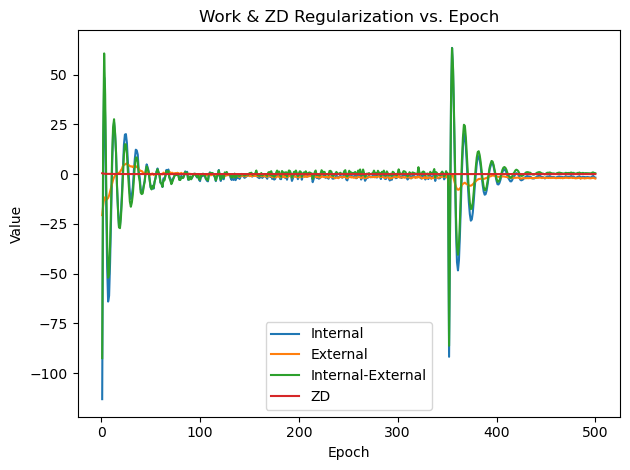

In [55]:
import matplotlib.pyplot as plt

# assume work_dict already exists, with lists of length N for each key
epochs = list(range(1, len(work_dict['Internal']) + 1))
# turn your lists into arrays
internal = np.array(work_dict['Internal'])
external = np.array(work_dict['External'])

# now subtraction works element‐wise
diff = internal - external
plt.figure()
plt.plot(epochs, work_dict['Internal'], label='Internal')
plt.plot(epochs, work_dict['External'], label='External')
plt.plot(epochs,diff, label='Internal-External')
plt.plot(epochs, work_dict['ZD'], label='ZD')
#plt.plot(epochs, work_dict['Special'], label='Special')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Work & ZD Regularization vs. Epoch')

plt.legend()
plt.tight_layout()
plt.show()


## Export

In [56]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)

In [57]:
for i in range(vf_number):
    tensor1 = VF_values[i,:,:].cpu()        # shape [1000,3]

    name='multi_VF_'+str(i)+'.txt'
    with open(name,'w') as f:
        for i, (x, y, z) in enumerate(tensor1.tolist(), start=1):
            f.write(f"{i},{x},{y},{z}\n")


# Parameter Recovery

In [86]:
model.eval()
time_idx=10

V_NN=model(x_input[:,:,time_idx]) #This is N elements x12 , output is 30,1

delta_xyz=calculate_point(centroids_tensor, time_idx) #This is N elements x3

#Vx=construct_VF_gradients_batch(V_NN[0:10],delta_xyz)
VF_values = evaluate_vf_values(V_NN, delta_xyz) #This is p, N, 3 (V_NN[10:20],delta_xyz)
#Vz=construct_VF(V_NN[20:30],delta_xyz)

#VF=torch.cat((Vx.unsqueeze(1),Vy.unsqueeze(1),Vz.unsqueeze(1)), dim=1)
grad_VF= construct_VF_gradients_batch(V_NN, delta_xyz)

#Strain
virtual_strain=0.5*(grad_VF+grad_VF.transpose(2,3)) #.detach().cpu().numpy()

In [59]:
V_NN.shape

torch.Size([2, 30])

In [60]:
print_vf_equations(V_NN[0], fmt="{:+.3f}")

Vx(x,y,z) = -0.008*1 + +0.038*x + -0.058*y + +0.035*z + -0.001*x**2 + -0.032*x*y + +0.008*x*z + +0.010*y**2 + -0.056*y*z + +0.118*z**2
Vy(x,y,z) = -0.159*1 + -0.120*x + -0.391*y + -0.579*z + +0.595*x**2 + -0.173*x*y + +0.680*x*z + -0.003*y**2 + +0.252*y*z + +0.122*z**2
Vz(x,y,z) = -0.116*1 + +0.053*x + -0.191*y + +0.234*z + -0.186*x**2 + -0.061*x*y + -0.374*x*z + +0.080*y**2 + -0.038*y*z + -0.079*z**2


In [61]:
print_vf_equations(V_NN[1], fmt="{:+.3f}")

Vx(x,y,z) = +0.007*1 + +0.150*x + +0.220*y + -0.098*z + -0.013*x**2 + +0.215*x*y + -0.041*x*z + +0.165*y**2 + -0.002*y*z + -0.468*z**2
Vy(x,y,z) = +0.047*1 + -0.074*x + -0.102*y + +0.172*z + -0.077*x**2 + -0.243*x*y + -0.097*x*z + +0.000*y**2 + +0.156*y*z + +0.268*z**2
Vz(x,y,z) = +0.013*1 + -0.020*x + +0.224*y + +0.433*z + +0.383*x**2 + +0.220*x*y + -0.315*x*z + -0.013*y**2 + +0.019*y*z + +0.150*z**2


In [62]:
VF_values.shape

torch.Size([2, 125, 3])

In [63]:
#Surface integral
t_surface=pressure_normals[:,:,s]*10000 #t_surface is N,3 (elements x xyz)
#   print(f'W_int shape: {W_int.shape}')
dot = (VF_values[:,pressure_element_IDs_final,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

W_ext=(dot*area_normals[:,:,s].T)

## Lambda term

$$
I_\lambda \;=\; \int_{V}
\bigl(\varepsilon_{xx} + \varepsilon_{yy} + \varepsilon_{zz}\bigr)\,
\bigl(\dot\varepsilon_{xx} + \dot\varepsilon_{yy} + \dot\varepsilon_{zz}\bigr)\,
\mathrm{d}V.
$$


In [72]:
eps_xx.shape,trace_eps.shape, trace_eps_dot.shape, virtual_strain[:, 0, 0].shape, virtual_strain.shape

((125,), (125,), (2, 3), (2, 3), (2, 125, 3, 3))

In [74]:
strain_tensor.shape, virtual_strain.shape

(torch.Size([125, 6, 11]), (2, 125, 3, 3))

In [66]:
# 1) extract the normal‐strain components from strain_tensor:
eps_xx = strain_tensor[:, 0,time_idx].detach().cpu().numpy()  # (1000,)
eps_yy = strain_tensor[:, 1,time_idx].detach().cpu().numpy()
eps_zz = strain_tensor[:, 2,time_idx].detach().cpu().numpy()

# 2) build the traces:
trace_eps     = eps_xx + eps_yy + eps_zz                   # (1000,)
trace_eps_dot = (
    virtual_strain[:, 0, 0]
  + virtual_strain[:, 1, 1]
  + virtual_strain[:, 2, 2]
)  # (1000,)

# 3) form I_lambda integrand at each point:
I_lambda_pt = trace_eps * trace_eps_dot* volume_tensor[:,0,time_idx].detach().cpu().numpy()  # (1000,1)
I_lambda_pt.shape

ValueError: operands could not be broadcast together with shapes (125,) (2,3) 

In [75]:
#Now the A matrix:

A1= (ε_xx+ε_yy+ε_zz)*(εd_xx+εd_yy+εd_zz)* volume_tensor[:,0,s]
A2= (ε_xx * εd_xx + ε_yy * εd_yy +ε_zz * εd_zz +2 * (ε_xy * εd_xy +ε_yz * εd_yz +ε_zx * εd_zx))* volume_tensor[:,0,s]

# print(A1.sum().item())
#print(A2.sum().item())
#
A = torch.stack([A1, A2], dim=1)  # -> (1000,6)
M = A.mean(dim=2)                   # shape (2, 2):  M[k] = [ I_v^(k), I_d^(k) ]


In [76]:
M.shape

torch.Size([2, 2])

In [77]:
M

tensor([[ 2.0553e-05, -6.0204e-06],
        [-1.8368e-05,  8.3158e-08]], dtype=torch.float32,
       grad_fn=<MeanBackward1>)

In [100]:
#Volume integral:
s=9
# element‐wise inner product σ^e : ∇v^e
integrand = torch.sum(stress_tensor_3d[:,:,:,s].unsqueeze(0) * virtual_strain, dim=(2, 3)) # → shape [p,N]
# print(f'Integrand shape: {integrand.shape}')
W_int = torch.sum(integrand * volume_tensor[:,0,s].unsqueeze(0) ,dim=(0,1))/(Nelements*vf_number)

# print(f'W_int shape: {W_int.shape}')
#Surface integral
#Adding negative to the pressure becuase it is applied downwards...
t_surface=surface_normal_tensor[facet_idxs,:,s]*(-100000)*area_tensor[facet_idxs,:,s] #t_surface is N_pressure,3 (elements x xyz), add area because pressure is not force
#   print(f'W_int shape: {W_int.shape}')
dot = (VF_values[:,elem_idxs,:]* t_surface.unsqueeze(0)).sum(dim=2)  # shape: [3, 100]

W_ext=torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(1))/(N_pressure_dofs*vf_number)


In [101]:
dot.shape,torch.sum(dot*area_tensor[facet_idxs,:,s].T,dim=(1)).shape

(torch.Size([2, 25]), torch.Size([2]))

In [102]:
torch.matmul(W_ext,torch.inverse(M))

tensor([3510329., 2908947.], dtype=torch.float32, grad_fn=<SqueezeBackward4>)

In [103]:
M

tensor([[ 2.0553e-05, -6.0204e-06],
        [-1.8368e-05,  8.3158e-08]], dtype=torch.float32,
       grad_fn=<MeanBackward1>)